In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [ ]:
# change the path if necessary
df = pd.read_csv('/content/drive/MyDrive/Rakamin/data/botak.csv')

In [ ]:
# informasi general tentang dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   umur           7991 non-null   float64
 1   jenis_kelamin  7982 non-null   object 
 2   pekerjaan      7924 non-null   object 
 3   provinsi       7991 non-null   object 
 4   gaji           7968 non-null   float64
 5   is_menikah     7991 non-null   int64  
 6   is_keturunan   7976 non-null   float64
 7   berat          7952 non-null   float64
 8   tinggi         7991 non-null   float64
 9   sampo          7934 non-null   object 
 10  is_merokok     7991 non-null   int64  
 11  pendidikan     7991 non-null   object 
 12  botak_prob     7991 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 811.7+ KB


Pengamatan\:
1. Data terdiri dari 7991 baris
2. Tampak beberapa kolom masih memiliki null/missing values (Non-Null Count < jumlah baris)
3. Sepertinya tidak ada issue yang mencolok pada tipe data untuk setiap kolom (sudah sesuai)

## Cuplikan Data

In [ ]:
# run code ini beberapa kali
df.sample(5)

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,botak_prob
6975,41.0,Perempuan,PNS,Mamuju,1.035433e+07,0,0.0,NaN,155.796744,Deadbuoy,1,S2,0.350974
7761,56.0,Laki-laki,PNS,Kupang,7.271212e+06,0,0.0,49.092646,155.165758,Merpati,0,SMA,0.468846
1580,35.0,Laki-laki,Pegawai swasta,Surabaya,3.267107e+06,0,1.0,47.166522,149.841292,Shoulder & Head,0,S1,0.556467
5980,34.0,Perempuan,Pegawai swasta,Padang,9.716079e+06,0,0.0,51.952467,161.438785,Deadbuoy,0,SMA,0.070974
7460,39.0,Perempuan,Pegawai swasta,Tanjung Pinang,3.753108e+06,0,0.0,74.279051,158.748959,Pantone,1,S1,0.187188


Seperti inspeksi kita kemarin, semuanya cenderung AMAN.

# Statistical Summary

In [ ]:
# pengelompokan kolom berdasarkan jenisnya
nums = ['umur', 'gaji', 'is_menikah', 'is_keturunan', 'berat', 'tinggi', 'is_merokok', 'botak_prob']
cats = ['jenis_kelamin', 'pekerjaan', 'provinsi', 'sampo', 'pendidikan']

In [ ]:
# ringkasan statistik dari kolom numerik
df[nums].describe()

,umur,gaji,is_menikah,is_keturunan,berat,tinggi,is_merokok,botak_prob
count,7991.000000,7.968000e+03,7991.000000,7976.000000,7952.000000,7991.000000,7991.000000,7991.000000
mean,39.604805,9.466150e+06,0.030284,0.193455,56.449251,157.547757,0.499312,0.395915
std,10.014420,4.809191e+06,0.171379,0.395032,9.581271,6.568111,0.500031,0.191092
min,3.000000,1.500000e+06,0.000000,0.000000,40.000000,136.197006,0.000000,-0.115700
25%,33.000000,6.109338e+06,0.000000,0.000000,49.919026,153.093636,0.000000,0.260501
50%,40.000000,8.412740e+06,0.000000,0.000000,54.237651,157.233899,0.000000,0.372669
75%,46.000000,1.153660e+07,0.000000,0.000000,60.770302,161.548151,1.000000,0.511974
max,78.000000,5.000000e+07,1.000000,1.000000,150.000000,200.225925,1.000000,1.000000


Beberapa pengamatan:
1. Kolom `umur`, `berat`, `tinggi`, dan `botak_prob` tampak sudah cukup simetrik distribusinya (mean dan median tak berbeda jauh)
2. Tampaknya ada issue pada nilai minimal untuk kolom `botak_prob` (bernilai negatif), akan di-drop di langkah selanjutnya
3. Kolom `gaji` tampaknya skew ke kanan (long-right tail), mungkin dapat dilakukan transformasi log nantinya
4. Kolom `is_menikah`, `is_keturunan`, dan `is_merokok` ternyata bernilai boolean/binary

In [ ]:
# categorical columns 
df[cats].describe()

,jenis_kelamin,pekerjaan,provinsi,sampo,pendidikan
count,7982,7924,7991,7934,7991
unique,2,4,34,5,6
top,Laki-laki,Pegawai swasta,Banda Lampung,Merpati,S1
freq,5342,3196,270,1652,4400


Beberapa pengamatan:
1. Data dinominasi (proporsi lebih dari 50% dari jumlah baris data) oleh kaum laki-laki (`jenis_kelamin`) dan S1 (`pendidikan`)
2. Kolom provinsi memiliki kardinalitas (jumlah unique values) yang cukup tinggi (34). Tampaknya kita perlu exclude fitur ini dari dataset untuk pemodelan.

## Drop baris dengan negative target values

In [ ]:
# hanya include baris dengan botak_prob NON-NEGATIVE
df = df.loc[df.botak_prob >= 0]

## Drop kolom `provinsi`

In [ ]:
# drop provinsi karena unique valuesnya terlalu banyak
df = df.drop(columns='provinsi')

# Missing Data

In [ ]:
# jumlah entry NULL di setiap kolom
df.isna().sum()

umur              0
jenis_kelamin     9
pekerjaan        67
gaji             23
is_menikah        0
is_keturunan     15
berat            39
tinggi            0
sampo            57
is_merokok        0
pendidikan        0
botak_prob        0
dtype: int64

Berikut adalah strategi kita mengatasi missing values pada setiap kolom. 
<br>
INGAT: jikalau kita melakukan imputasi, maka itu mencerminkan ASUMSI kita.
* `jenis_kelamin` & `is_keturunan` \: Drop saja (karena jumlahnya kecil)
* `pekerjaan` \: impute dengan nilai modus (Pegawai Swasta)
* `gaji` \: impute dengan nilai median (dari `df.describe` kita tau distribusinya skewed)
* `berat` \: impute dengan nilai average (dari `df.describe` kita tau distribusinya mendekati normal)
* `sampo` \: impute dengan nilai modus (Merpati)

In [ ]:
# drop `jenis_kelamin` & `is_keturunan`
df = df.dropna(subset=['jenis_kelamin','is_keturunan'])
df.isna().sum()

umur              0
jenis_kelamin     0
pekerjaan        67
gaji             23
is_menikah        0
is_keturunan      0
berat            39
tinggi            0
sampo            57
is_merokok        0
pendidikan        0
botak_prob        0
dtype: int64

In [ ]:
# Impute pekerjaan dan sampo dengan modus
df['pekerjaan'].fillna(df['pekerjaan'].mode()[0], inplace=True)
df['sampo'].fillna(df['sampo'].mode()[0], inplace=True)

In [ ]:
# impute gaji dan berat
df['gaji'].fillna(df['gaji'].median(), inplace=True)
df['berat'].fillna(df['berat'].mean(), inplace=True)

In [ ]:
# cek jumlah missing data setelah preprocessing
df.isna().sum()

umur             0
jenis_kelamin    0
pekerjaan        0
gaji             0
is_menikah       0
is_keturunan     0
berat            0
tinggi           0
sampo            0
is_merokok       0
pendidikan       0
botak_prob       0
dtype: int64

# Duplicated Data

In [ ]:
# cek jumlah duplicated rows
# dari semua kolom
df.duplicated().sum()

101

In [ ]:
# cek jumlah duplicated rows
# dari 3 kolom saja (umur, sampo, berat)
# untuk mengetes pemahaman saja
df.duplicated(subset=['umur','sampo', 'berat']).sum()

124

In [ ]:
# drop duplicated rows
print(f'Jumlah row duplicated sebelum dihapus {df.duplicated().sum()}')
df.drop_duplicates(inplace=True) # note: default-nya keep='First' (tidak perlu ditulis)
print(f'Jumlah row duplicated SETELAH dihapus {df.duplicated().sum()}')

Jumlah row duplicated sebelum dihapus 101
Jumlah row duplicated SETELAH dihapus 0


In [ ]:
df = df.drop_duplicates()

In [ ]:
df[df.duplicated(keep=False).index]

# Outliers Handling
Kita akan menggunakan Z-score filtering (cenderung lebih konservatif)

In [ ]:
from scipy import stats

In [ ]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in nums:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 7828
Jumlah baris setelah memfilter outlier: 7298


# Log/Exp Transformation

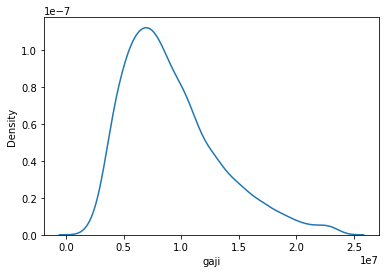

In [ ]:
# distribusi gaji (nilai asli)
sns.kdeplot(df['gaji'])

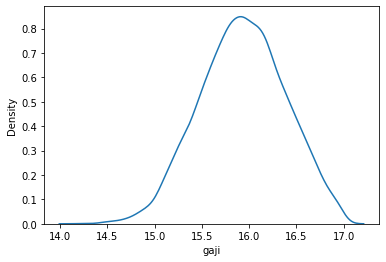

In [ ]:
# distribusi gaji (setelah log transformation)
sns.kdeplot(np.log(df['gaji']))
# lebih mendekati distribusi normal!

In [ ]:
# kita tranformasi
df['log_gaji'] = np.log(df['gaji'])

# drop kolom gaji (nilai asli)
df = df.drop(columns='gaji')

# Normalization/Standardization

In [ ]:
df.describe()

,umur,is_menikah,is_keturunan,berat,tinggi,is_merokok,botak_prob,log_gaji
count,7298.000000,7298.0,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000
mean,38.987668,0.0,0.191148,55.821403,157.238553,0.501918,0.388456,15.931813
std,9.243934,0.0,0.393232,8.164461,6.079853,0.500031,0.180737,0.450526
min,10.000000,0.0,0.000000,40.000000,138.134574,0.000000,0.002085,14.220976
25%,33.000000,0.0,0.000000,49.887324,153.028716,0.000000,0.258892,15.622713
50%,39.000000,0.0,0.000000,54.136307,157.067361,1.000000,0.368188,15.936654
75%,46.000000,0.0,0.000000,60.262541,161.304694,1.000000,0.498574,16.246243
max,58.000000,0.0,1.000000,84.999782,177.244847,1.000000,0.957788,16.983036


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# berat dan tinggi kita re-scale ke [0,1]
df['berat_norm'] = MinMaxScaler().fit_transform(df['berat'].values.reshape(len(df), 1))
df['tinggi_norm'] = MinMaxScaler().fit_transform(df['tinggi'].values.reshape(len(df), 1))

# umur dan log gaji kita standarisasi (karena distribusi datanya sudah mendekati normal)
df['umur_std'] = StandardScaler().fit_transform(df['umur'].values.reshape(len(df), 1))
df['log_gaji_std'] = StandardScaler().fit_transform(df['log_gaji'].values.reshape(len(df), 1))

In [ ]:
# cek keberhasilan feature transformation
df.describe()

,umur,is_menikah,is_keturunan,berat,tinggi,is_merokok,botak_prob,log_gaji,berat_norm,tinggi_norm,umur_std,log_gaji_std
count,7298.000000,7298.0,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7.298000e+03,7.298000e+03
mean,38.987668,0.0,0.191148,55.821403,157.238553,0.501918,0.388456,15.931813,0.351588,0.488464,-2.518007e-16,-5.035861e-16
std,9.243934,0.0,0.393232,8.164461,6.079853,0.500031,0.180737,0.450526,0.181433,0.155454,1.000069e+00,1.000069e+00
min,10.000000,0.0,0.000000,40.000000,138.134574,0.000000,0.002085,14.220976,0.000000,0.000000,-3.136073e+00,-3.797685e+00
25%,33.000000,0.0,0.000000,49.887324,153.028716,0.000000,0.258892,15.622713,0.219719,0.380824,-6.477846e-01,-6.861336e-01
50%,39.000000,0.0,0.000000,54.136307,157.067361,1.000000,0.368188,15.936654,0.314142,0.484087,1.334171e-03,1.074594e-02
75%,46.000000,0.0,0.000000,60.262541,161.304694,1.000000,0.498574,16.246243,0.450281,0.592431,7.586394e-01,6.979657e-01
max,58.000000,0.0,1.000000,84.999782,177.244847,1.000000,0.957788,16.983036,1.000000,1.000000,2.056877e+00,2.333487e+00


# Feature Encoding

In [ ]:
cats_updated = ['jenis_kelamin', 'pekerjaan', 'sampo', 'pendidikan']

for col in cats_updated:
  print(f'value counts of column {col}')
  print(df[col].value_counts())
  print('---'*10, '\n')

value counts of column jenis_kelamin
Laki-laki    4897
Perempuan    2401
Name: jenis_kelamin, dtype: int64
------------------------------ 

value counts of column pekerjaan
PNS               3016
Pegawai swasta    2928
Freelance         1097
Pengangguran       257
Name: pekerjaan, dtype: int64
------------------------------ 

value counts of column sampo
Merpati            1539
Pantone            1464
Moonsilk           1439
Deadbuoy           1434
Shoulder & Head    1422
Name: sampo, dtype: int64
------------------------------ 

value counts of column pendidikan
S1     4007
SMA    1853
S2      600
SMP     503
SD      199
S3      136
Name: pendidikan, dtype: int64
------------------------------ 



Strategi encoding
* `jenis_kelamin` & `pendidikan` \: label encoding
* `pekerjaan` & 'sampo` \: One Hot Encoding 

In [ ]:
# jenis_kelamin & pendidikan
mapping_jenis_kelamin = {
    'Perempuan' : 0,
    'Laki-laki' : 1
}

mapping_pendidikan = {
    'SD' : 0,
    'SMP' : 1,
    'SMA' : 2,
    'S1' : 3,
    'S2' : 4,
    'S3' : 5
}

df['jenis_kelamin'] = df['jenis_kelamin'].map(mapping_jenis_kelamin)
df['pendidikan'] = df['pendidikan'].map(mapping_pendidikan)

In [ ]:
# One hot encoder pekerjaan dan sampo
# WARNING: run code ini sekali saja
for cat in ['pekerjaan', 'sampo']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

# Drop kolom-kolom yang outdated

In [ ]:
# drop kolom pekerjaan dan sampo yang asli (karena sudah di-encoding)
df = df.drop(columns=['pekerjaan', 'sampo','umur','berat', 'tinggi','log_gaji'])

In [ ]:
df.head()

,jenis_kelamin,is_menikah,is_keturunan,is_merokok,pendidikan,botak_prob,berat_norm,tinggi_norm,umur_std,log_gaji_std,pekerjaan_Freelance,pekerjaan_PNS,pekerjaan_Pegawai swasta,pekerjaan_Pengangguran,sampo_Deadbuoy,sampo_Merpati,sampo_Moonsilk,sampo_Pantone,sampo_Shoulder & Head
0,1,0,0.0,1,3,0.487655,0.487306,0.358974,0.325894,-0.119882,0,1,0,0,1,0,0,0,0
1,1,0,0.0,1,2,0.297270,0.208323,0.375564,-0.647785,-0.545244,0,0,1,0,0,0,1,0,0
3,1,0,1.0,0,3,0.616418,0.629737,0.624501,-0.106852,0.718571,0,0,1,0,0,0,1,0,0
4,0,0,0.0,1,4,0.115439,0.306001,0.420476,-0.647785,1.277660,1,0,0,0,0,0,0,1,0
5,1,0,0.0,0,2,0.303799,0.548662,0.409961,0.001334,0.611859,0,0,1,0,0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7298 entries, 0 to 7989
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jenis_kelamin             7298 non-null   int64  
 1   is_menikah                7298 non-null   int64  
 2   is_keturunan              7298 non-null   float64
 3   is_merokok                7298 non-null   int64  
 4   pendidikan                7298 non-null   int64  
 5   botak_prob                7298 non-null   float64
 6   berat_norm                7298 non-null   float64
 7   tinggi_norm               7298 non-null   float64
 8   umur_std                  7298 non-null   float64
 9   log_gaji_std              7298 non-null   float64
 10  pekerjaan_Freelance       7298 non-null   uint8  
 11  pekerjaan_PNS             7298 non-null   uint8  
 12  pekerjaan_Pegawai swasta  7298 non-null   uint8  
 13  pekerjaan_Pengangguran    7298 non-null   uint8  
 14  sampo_De

# Imbalanced Dataset
INGAT: Process data preprocessing kita (untuk pemodelan `botak_prob` sebenarnya sudah selesai per df.info() di atas).
<br>
<br>
Section ini hanya **hypothetical** saja (untuk demonstrasi metode handling data imbalance)

In [ ]:
# pembuatan binary label target
df['botak_class'] = df['botak_prob'] > 0.8
df['botak_class'].value_counts()

False    7127
True      171
Name: botak_class, dtype: int64

In [ ]:
# pemisahan features vs target
X = df[[col for col in df.columns if (str(df[col].dtype) != 'object') and col not in ['botak_prob', 'botak_class']]]
y = df['botak_class'].values
print(X.shape)
print(y.shape)

(7298, 18)
(7298,)


In [ ]:
from imblearn import under_sampling, over_sampling
X_under, y_under = under_sampling.RandomUnderSampler(0.5).fit_resample(X, y)
X_over, y_over = over_sampling.RandomOverSampler(0.5).fit_resample(X, y)
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(0.5).fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [ ]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('UNDERSAMPLING')
print(pd.Series(y_under).value_counts())
print('\n')
print('OVERSAMPLING')
print(pd.Series(y_over).value_counts())
print('\n')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
False    7127
True      171
dtype: int64


UNDERSAMPLING
False    342
True     171
dtype: int64


OVERSAMPLING
False    7127
True     3563
dtype: int64


SMOTE
False    7127
True     3563
dtype: int64
